# an emission spectrum  check CO



This code compares a CO emission spectrum (HITEMP) between exojax and petitRadtran

author: Hajime Kawahara

last update: March 16th (2021)

In [3]:
from exojax.spec import rtransfer as rt
from exojax.spec import planck
from exojax.spec import moldb
from exojax.spec import make_numatrix0
from exojax.spec.lpf import xsmatrix
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.plot.atmplot import plottau, plotcf
from exojax.spec.rtransfer import rtrun, rtrun_direct, dtaux 

import numpy as np
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import jax.numpy as jnp
from jax import random
from jax import vmap, jit
plt.style.use('bmh')

## INPUT MODEL

In [5]:
N=20000
wav=np.linspace(23000.0,24000.0,N,dtype=np.float64)#AA
nus=1.e8/wav[::-1]

#loading molecular database
mdbCO=moldb.MdbHit('/home/kawahara/exojax/data/hitemp/CO/05_HITEMP2019.par',nus)

In [6]:
#petitRadtran
dat=pd.read_csv("co_exojax/Gl229/Gl229B_spectrum_CO.dat",delimiter=" ",names=("WAV","VAL"))

NP=130
Nspecies=160
Parr=np.ones(NP)
Tarr=np.ones(NP)

### read header
data = open('co_exojax/Gl229/MMR/eq.dat', 'r')
line = data.read().split()
data.close()
molname = {}
for a in range(0,160):
    molname[a] = line[a+6]

data = open('co_exojax/Gl229/MMR/eq.dat', 'r')
a = 0
MMW_k = np.ones_like(Tarr)
MMR = np.zeros((Nspecies,NP))
for line in data:
    if line[0]=='#':
        continue
    lines = line.rstrip('\n').split()
    Parr[a] = lines[0]
    Tarr[a] = lines[1]
    MMW_k[a] = lines[2]
    for i in range(0,160):
        MMR[i,a] = lines[i+3]
    a = a + 1
data.close()

Tarr=jnp.array(Tarr)
Parr=jnp.array(Parr)

In [7]:
from exojax.utils.chopstacks import buildwall 
wParr=buildwall(Parr)
dParr=wParr[1:]-wParr[0:-1]

In [8]:
#partition function ratio
#mdbCO_HITRAN=moldb.MdbHit('/home/kawahara/exojax/data/CO','05_hit12',nus)
mdbCO_hitran=moldb.MdbHit('/home/kawahara/exojax/data/CO/05_hit12.par',nus)
qr=mdbCO_hitran.Qr(Tarr)

In [9]:
#partitioning Q(T) for each line
qt=np.zeros((NP,len(mdbCO.isoid)))
for idx,iso in enumerate(mdbCO.uniqiso):
    mask=mdbCO.isoid==iso
    for ilayer in range(NP):
        qt[ilayer,mask]=qr[ilayer,idx]

In [42]:
molmass=28.01 #molecular mass
mmr=0.01 #mass mixing ratio
g=1.e5 # gravity cm/s2

#vmr=mmr*mmw/molmass 
#mmw=2.33 #mean molecular weight

In [11]:
SijM=vmap(SijT,(0,None,None,None,0))(Tarr,mdbCO.logsij0,mdbCO.nu_lines\
                                          ,mdbCO.elower,qt)
gammaLM = vmap(gamma_hitran,(0,0,0,None,None,None))\
(Parr,Tarr,Parr, mdbCO.n_air, mdbCO.gamma_air, mdbCO.gamma_self)
+ gamma_natural(mdbCO.A) #uncomment if you inclide a natural width
sigmaDM=vmap(doppler_sigma,(None,0,None))(mdbCO.nu_lines,Tarr,molmass)

In [12]:
nu0=mdbCO.nu_lines
memory_size=15.0

d=int(memory_size/(len(nu0)*4/1024./1024.))
Ni=int(len(nus)/d)

d2=100
Nlayer=np.shape(SijM)[0]
Nline=np.shape(SijM)[1]
Nj=int(Nline/d2)
xsm=[]
for i in tqdm.tqdm(range(0,Ni+1)):
    s=int(i*d);e=int((i+1)*d);e=min(e,len(nus))
    xsmtmp=np.zeros((Nlayer,e-s))
    #line 
    for j in range(0,Nj+1):
        s2=int(j*d2);e2=int((j+1)*d2);e2=min(e2,Nline)
        numatrix=make_numatrix0(nus[s:e],nu0[s2:e2])
        xsmtmp=xsmtmp+\
        xsmatrix(numatrix,sigmaDM[:,s2:e2],gammaLM[:,s2:e2],SijM[:,s2:e2])
    if i==0:
        xsm=np.copy(xsmtmp.T)
    else:
        xsm = np.concatenate([xsm,xsmtmp.T])
xsm=xsm.T



100%|██████████| 158/158 [02:08<00:00,  1.24s/it]


## cheking d tau and contribution function

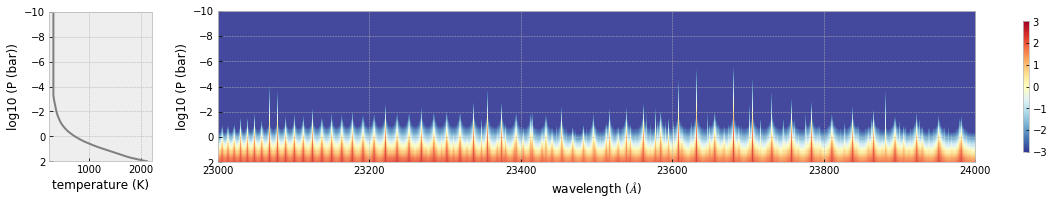

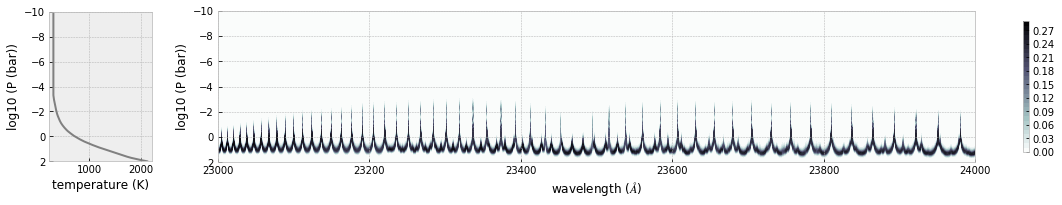

In [30]:
dtauM=dtaux(dParr,xsm,mmr*np.ones_like(Parr),molmass,g)
plottau(nus,dtauM,Tarr,Parr,unit="AA") #tau
plt.savefig("../../documents/figures/plottau.png")
plotcf(nus,dtauM,Tarr,Parr,dParr,unit="AA") 
plt.savefig("../../documents/figures/plotcf.png")

In [46]:
sourcef=planck.piBarr(Tarr,nus)
Fx0=rtrun(dtauM,sourcef)
#Fx0_direct=rtrun_direct(dtauM,sourcef,1.0) #mu=1
#Fx0_direct=rtrun_direct(dtauM,sourcef)
#Fx0_direct=rtrun_direct(dtauM/0.5,sourcef) #=0.5

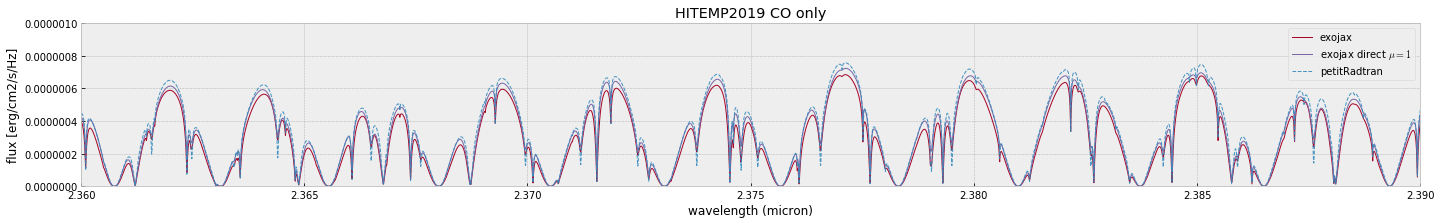

In [47]:
fig=plt.figure(figsize=(24,3))
ax=fig.add_subplot(111)
plt.plot(1.e4/nus,Fx0,lw=1,alpha=1.0,label="exojax",color="C1")
plt.plot(1.e4/nus,Fx0_direct,lw=1,alpha=1.0,label="exojax direct $\mu=1$",color="C2")
plt.plot(dat["WAV"],dat["VAL"],lw=1,alpha=0.9,ls="dashed",label="petitRadtran")

### ISO LINE
if False:
    Smax=(np.max(SijM,axis=0))
    crit=-24
    for iso in mdbCO.uniqiso:
        mask=(mdbCO.isoid==iso)*(np.log10(Smax)>crit)
        wiso=1.e4/nu0[mask]
        for w in wiso:
            plt.axvline(w,color="C"+str(iso),alpha=0.1)

    #iso just for label
    for iso in mdbCO.uniqiso:
        plt.axvline([1.0],color="C"+str(iso),alpha=0.3,label="iso="+str(iso))
###

plt.xlim(2.36,2.39)
#plt.xlim(2.3,2.4)
plt.ylim(0.0,1.e-6)
plt.xlabel("wavelength (micron)")
plt.ylabel("flux [erg/cm2/s/Hz]")
plt.title("HITEMP2019 CO only")
plt.legend()
plt.savefig("test_CO.png", bbox_inches="tight", pad_inches=0.0)